[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-3/dynamic-breakpoints.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239526-lesson-4-dynamic-breakpoints)

# 동적인 Breakpoint

특정 단계에서 그래프를 멈추는 일반적인 방법으로 중단점을 다루었으며, 이를 통해 '승인'과 같은 사용 사례를 구현할 수 있습니다.

또한 그래프 상태를 편집하는 방법과 사람의 피드백을 도입하는 방법도 소개했습니다. 

중단점은 개발자가 그래프를 컴파일하는 동안 특정 노드에 설정합니다.

하지만 때로는 그래프가 동적으로 중단되도록 하는 것이 유용할 때가 있습니다!

이것은 내부 중단점이며, NodeInterrupt를 사용하여 달성할 수 있습니다.

여기에는 몇 가지 구체적인 이점이 있습니다:

(1) 개발자가 정의한 로직에 따라 노드 내부에서 조건부로 수행할 수 있습니다.

(2) 사용자에게 인터럽트 이유를 전달할 수 있습니다(원하는 내용을 NodeInterrupt에 전달하여).

그러면, 다음 예제를 통해서 입력의 길이에 따라 NodeInterrupt가 발생하는 그래프를 만들어 보겠습니다.

## 패키지 설치

In [3]:
%%capture --no-stderr
%pip install --quiet -U langgraph langgraph_sdk

## Bedrock setup

In [4]:
import os
import getpass
import boto3
from langchain_aws import ChatBedrockConverse
from langchain_aws import ChatBedrock

# ---- ⚠️ Update region for your AWS setup ⚠️ ----
aws_region = os.getenv("AWS_REGION")
bedrock_client = boto3.client("bedrock-runtime", region_name=aws_region)

llm = ChatBedrockConverse(
    model="anthropic.claude-3-haiku-20240307-v1:0",
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
    # other params...
)

llm.invoke("what is the Amazon Nova?")

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


## 그래프 생성

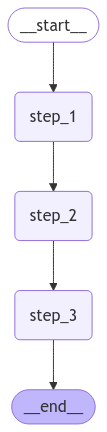

In [5]:
from IPython.display import Image, display

from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.errors import NodeInterrupt
from langgraph.graph import START, END, StateGraph

class State(TypedDict):
    input: str

def step_1(state: State) -> State:
    print("---Step 1---")
    return state

def step_2(state: State) -> State:
    # Let's optionally raise a NodeInterrupt if the length of the input is longer than 5 characters
    print("--Step 2 (before Node Interrupt)--")
    if len(state['input']) > 5:
        raise NodeInterrupt(f"Received input that is longer than 5 characters: {state['input']}")
    
    print("---Step 2---")
    return state

def step_3(state: State) -> State:
    print("---Step 3---")
    return state

builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Compile the graph with memory
graph = builder.compile(checkpointer=memory)

# View
display(Image(graph.get_graph().draw_mermaid_png()))

5자보다 긴 글자 입력으로 그래프를 실행해 보겠습니다.

In [6]:
initial_input = {"input": "hello world"}
thread_config = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---
{'input': 'hello world'}
--Step 2 (before Node Interrupt)--


이 시점에서 그래프 상태를 검사하면, step_2가 다음 노드라고 가리키고 있음을 알 수 있습니다.

In [7]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


상세내용을 확인해 보면, `Interrupt`가 상태로 기록된 것을 볼 수 있습니다.

In [8]:
print(state.tasks)

(PregelTask(id='39005008-94cd-c3f2-e40e-638b2445966a', name='step_2', path=('__pregel_pull', 'step_2'), error=None, interrupts=(Interrupt(value='Received input that is longer than 5 characters: hello world', resumable=False, ns=None, when='during'),), state=None, result=None),)


중단점에서 그래프를 다시 시작할 수 있습니다.

하지만 이것은 동일한 노드를 다시 실행할 뿐입니다!

상태가 변경되지 않는 한 우리는 여기서 멈출 것입니다.

In [9]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hello world'}
--Step 2 (before Node Interrupt)--


In [10]:
state = graph.get_state(thread_config)
print(state.next)

('step_2',)


그래서 우리는 상태를 업데이트해서 이 상태를 벗어나게 할 것입니다.
이번에는 5자보다 적은 글자수를 입력하여 수행해 보입니다.

In [11]:
graph.update_state(
    thread_config,
    {"input": "hi"},
)

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1eff4f97-39ca-67f8-8002-98b845337fa1'}}

In [12]:
for event in graph.stream(None, thread_config, stream_mode="values"):
    print(event)

{'input': 'hi'}
--Step 2 (before Node Interrupt)--
---Step 2---
{'input': 'hi'}
---Step 3---
{'input': 'hi'}


In [13]:
state = graph.get_state(thread_config)
print(state.next)

()
